# Trabajo Práctico - Data Mining Avanzado

Universidad Austral 2025 

**Profesores:**
* Volpacchio, Martín


**Alumnas:**
* Alvaro, Giuliana
* Chalup, Sarah
* Franco, Agustina
* Guzman, Mariana

## Ejercicio 1

### Ejercicio I - Tipología de red neuronal

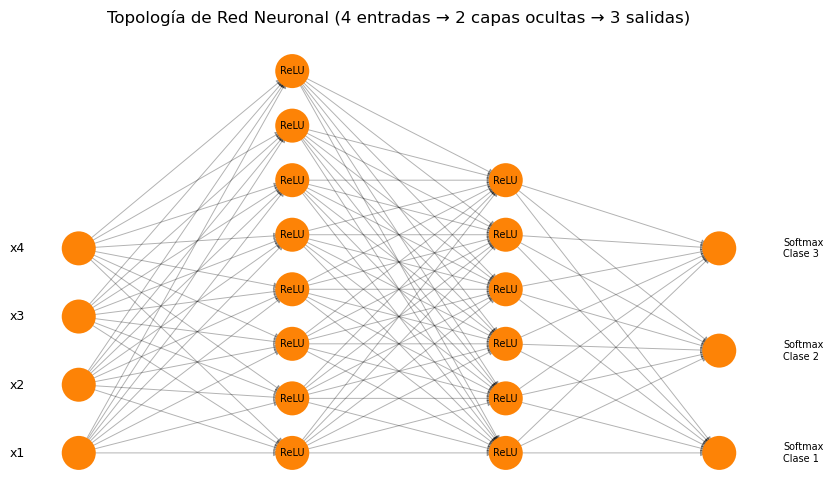

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Crear un grafo dirigido
G = nx.DiGraph()

# Definir nodos por capas
input_nodes = [f"x{i+1}" for i in range(4)]
hidden1_nodes = [f"h1_{i+1}" for i in range(8)]
hidden2_nodes = [f"h2_{i+1}" for i in range(6)]
output_nodes = [f"y{i+1}" for i in range(3)]

# Añadir nodos con posiciones para dibujar en capas
pos = {}

# Entrada
for i, node in enumerate(input_nodes):
    pos[node] = (0, i)

# Oculta 1
for i, node in enumerate(hidden1_nodes):
    pos[node] = (2, i*0.8)

# Oculta 2
for i, node in enumerate(hidden2_nodes):
    pos[node] = (4, i*0.8)

# Salida
for i, node in enumerate(output_nodes):
    pos[node] = (6, i*1.5)

# Añadir aristas (conexiones totalmente conectadas)
for n_in in input_nodes:
    for n_h1 in hidden1_nodes:
        G.add_edge(n_in, n_h1)

for n_h1 in hidden1_nodes:
    for n_h2 in hidden2_nodes:
        G.add_edge(n_h1, n_h2)

for n_h2 in hidden2_nodes:
    for n_out in output_nodes:
        G.add_edge(n_h2, n_out)

# Dibujar
# Dibujar red con estilo refinado
plt.figure(figsize=(10,6))

# Dibujar nodos como círculos sin borde, color específico
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="#fd8306", edgecolors="none")

# Dibujar conexiones (líneas más finas y suaves)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.7)

# Agregar etiquetas personalizadas
for node in input_nodes:
    plt.text(pos[node][0]-0.5, pos[node][1], node, fontsize=9, ha="right", va="center")

for node in hidden1_nodes:
    plt.text(pos[node][0], pos[node][1], "ReLU", fontsize=7, ha="center", va="center")

for node in hidden2_nodes:
    plt.text(pos[node][0], pos[node][1], "ReLU", fontsize=7, ha="center", va="center")

for i, node in enumerate(output_nodes):
    plt.text(pos[node][0]+0.6, pos[node][1], f"Softmax\nClase {i+1}", fontsize=7, ha="left", va="center")

plt.title("Topología de Red Neuronal (4 entradas → 2 capas ocultas → 3 salidas)", fontsize=12)
plt.axis("off")
plt.show()



### Ejercicio VI - Red LSTM

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [22]:
# 0) Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
# 1) Serie sintética: y = sin(t) + ruido
T = 1600
t = np.linspace(0, 60*np.pi, T)
y = np.sin(t) + 0.15*np.random.randn(T)  # cambialo por tu serie real si querés

# 2) Ventaneo para armar (X_seq -> y_target)
def make_sequences(series, window=30, horizon=1):
    X, Y = [], []
    for i in range(len(series) - window - horizon + 1):
        X.append(series[i:i+window])
        Y.append(series[i+window: i+window+horizon])
    X = np.array(X)[:, :, None]                # (muestras, pasos, features=1)
    Y = np.array(Y)[:, 0]                      # predecimos 1 paso adelante
    return X, Y

WINDOW = 30
X, Y = make_sequences(y, WINDOW, horizon=1)

In [24]:
# 3) Split train/val/test
n = len(X)
i_train = int(n*0.70)
i_val   = int(n*0.85)
X_train, y_train = X[:i_train], Y[:i_train]
X_val,   y_val   = X[i_train:i_val], Y[i_train:i_val]
X_test,  y_test  = X[i_val:], Y[i_val:]

In [25]:
# 4) Helper para construir modelos con diferentes configuraciones
def build_lstm(units_list, input_shape):
    model = Sequential()
    for i, u in enumerate(units_list):
        return_seq = (i < len(units_list)-1)   # True salvo en la última capa
        model.add(LSTM(u, return_sequences=return_seq,
                       input_shape=input_shape if i==0 else None))
    model.add(Dense(1))                        # salida escalar (1 paso)
    model.compile(optimizer="adam", loss="mse")
    return model


In [26]:
# 5) Configuraciones a comparar
configs = {
    "LSTM_32":           [32],          # 1 capa, 32 neuronas
    "LSTM_64":           [64],          # 1 capa, 64 neuronas
    "Stacked_50_20":     [50, 20],      # 2 capas (50 -> 20)
    "Stacked_64_64":     [64, 64],      # 2 capas (64 -> 64)
}

In [27]:
# 6) Entrenamiento, evaluación y predicción
es = EarlyStopping(patience=6, restore_best_weights=True, monitor="val_loss")

histories = {}
preds = {}
metrics = {}

for name, units in configs.items():
    print(f"\n=== Entrenando {name} ({units}) ===")
    model = build_lstm(units, input_shape=(WINDOW, 1))
    model.summary()
    histories[name] = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=60, batch_size=32, verbose=0, callbacks=[es]
    )
    # Predicción one-step en test (desplazada contra y_test)
    yhat = model.predict(X_test, verbose=0).squeeze()
    preds[name] = yhat
    rmse = np.sqrt(np.mean((yhat - y_test)**2))
    mae  = np.mean(np.abs(yhat - y_test))
    metrics[name] = (rmse, mae)
    print(f"{name}: RMSE={rmse:.4f} | MAE={mae:.4f} | Parámetros={model.count_params()}")


=== Entrenando LSTM_32 ([32]) ===


/Users/giulialvaro/miniconda3/envs/mcd-austral/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

LSTM_32: RMSE=0.1648 | MAE=0.1345 | Parámetros=4385

=== Entrenando LSTM_64 ([64]) ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

LSTM_64: RMSE=0.1872 | MAE=0.1505 | Parámetros=16961

=== Entrenando Stacked_50_20 ([50, 20]) ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,101 (62.89 KB)

 Trainable params: 16,101 (62.89 KB)

 Non-trainable params: 0 (0.00 B)

Stacked_50_20: RMSE=0.1617 | MAE=0.1304 | Parámetros=16101

=== Entrenando Stacked_64_64 ([64, 64]) ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Stacked_64_64: RMSE=0.1776 | MAE=0.1434 | Parámetros=49985


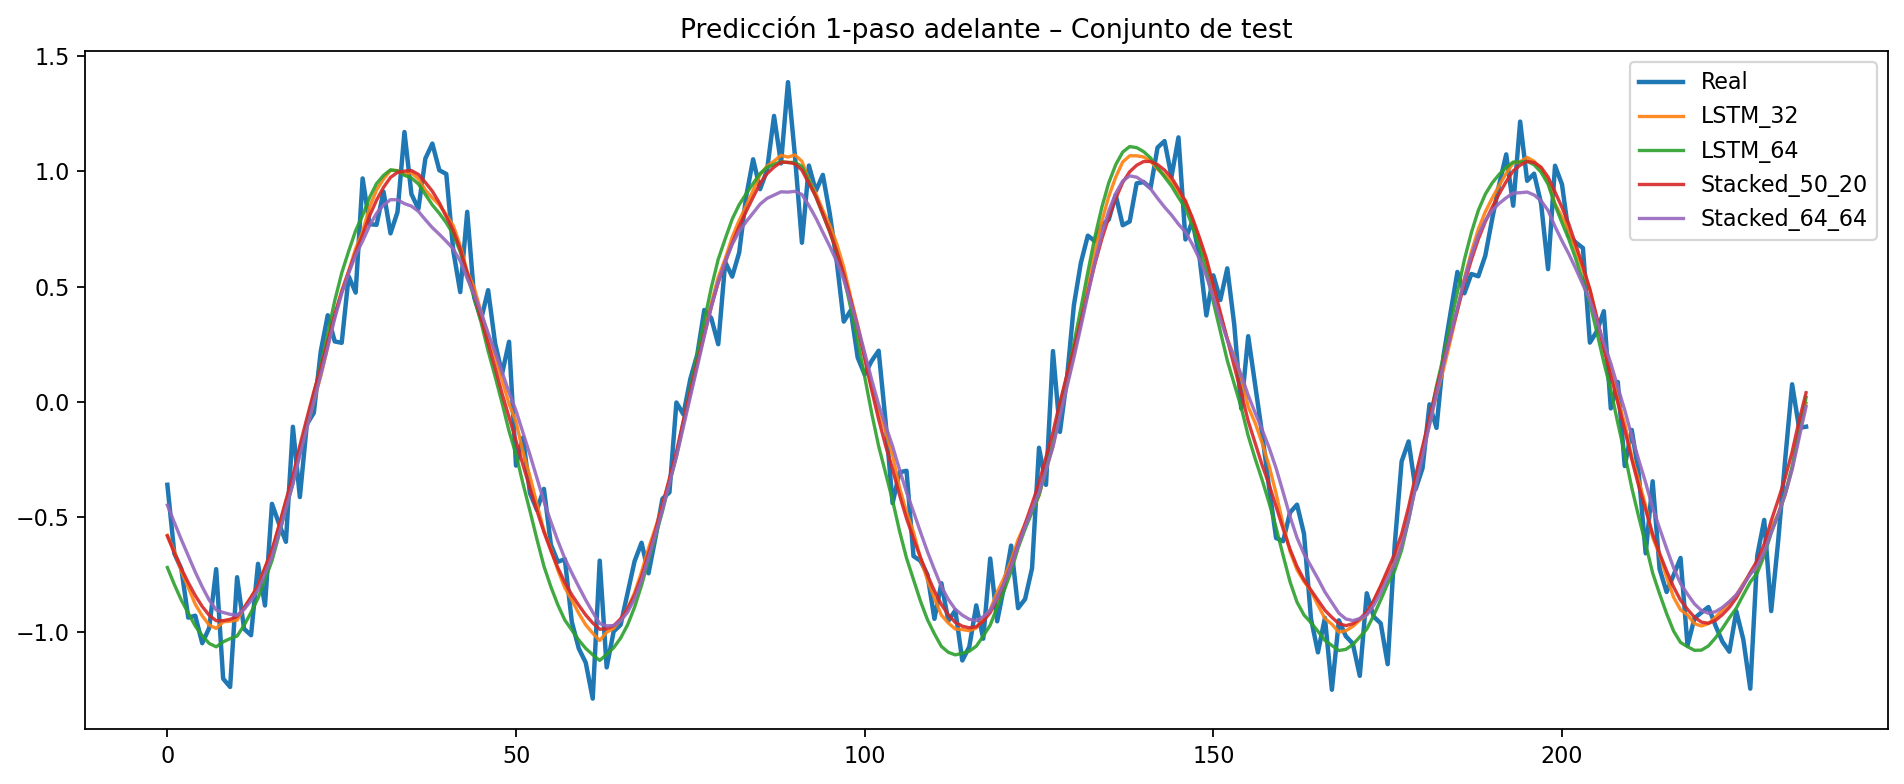

In [28]:
# 7) Visualización comparada (pred vs real) en TEST
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Real", linewidth=2)
for name, yhat in preds.items():
    plt.plot(yhat, label=name, alpha=0.9)
plt.title("Predicción 1-paso adelante – Conjunto de test")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# 8) Tabla simple de métricas
print("\n=== Métricas en TEST (menor es mejor) ===")
for name, (rmse, mae) in metrics.items():
    print(f"{name:>12}  RMSE={rmse:.4f}  MAE={mae:.4f}")


=== Métricas en TEST (menor es mejor) ===
     LSTM_32  RMSE=0.1648  MAE=0.1345
     LSTM_64  RMSE=0.1872  MAE=0.1505
Stacked_50_20  RMSE=0.1617  MAE=0.1304
Stacked_64_64  RMSE=0.1776  MAE=0.1434


### Ejercicio 7 - Reducción de dimensionalidad con t-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo (sustituir con datos reales de alta dimensión)
X = np.random.rand(100, 50)  # 100 muestras, 50 dimensiones

# Inicializar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Reducir la dimensionalidad
X_2d = tsne.fit_transform(X)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.title('Visualización de t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

### Resultados del Ejercicio 7

En este ejercicio se aplica la técnica de reducción de dimensionalidad **t-SNE (t-distributed Stochastic Neighbor Embedding)** sobre un conjunto de datos sintéticos de 50 dimensiones. El objetivo es proyectar los datos en un espacio bidimensional para facilitar su visualización e interpretación.

El parámetro `perplexity=30` controla el balance entre la atención local y global en la estructura de los datos. La visualización resultante permite observar agrupamientos latentes, relaciones de proximidad y posibles estructuras no lineales que no serían evidentes en el espacio original.

Esta técnica es especialmente útil en contextos de clustering, embeddings de texto o imágenes, y exploración de datos de alta dimensión. Para análisis más robustos, se recomienda combinar t-SNE con PCA o UMAP y aplicar sobre datos normalizados o preprocesados.

### Ejercicio 10 - Comparación de modelos supervisados (Regresión y Clasificación)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
# Modelos
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
# Dataset de Clasificación: Breast Cancer Wisconsin
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_class = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_class = cancer.target
# Dataset de Regresión: California Housing
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X_reg = pd.DataFrame(housing.data, columns=housing.feature_names)
y_reg = housing.target
# Separar datos
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
# Modelos y parámetros
models = {
    'SVM_reg': (SVR(), {'model__kernel': ['linear', 'rbf'], 'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}),
    'RandomForest_reg': (RandomForestRegressor(), {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10]}),
    'GradientBoosting_reg': (GradientBoostingRegressor(), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}),
    'MLP_reg': (MLPRegressor(max_iter=1000), {'model__hidden_layer_sizes': [(50,), (100,)], 'model__activation': ['relu', 'tanh'], 'model__alpha': [0.0001, 0.001]}),
    'SVM_class': (SVC(), {'model__kernel': ['linear', 'rbf'], 'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto'], 'model__probability': [True]}),
    'RandomForest_class': (RandomForestClassifier(), {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10]}),
    'GradientBoosting_class': (GradientBoostingClassifier(), {'model__n_estimators': [100, 200], 'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5]}),
    'MLP_class': (MLPClassifier(max_iter=1000), {'model__hidden_layer_sizes': [(50,), (100,)], 'model__activation': ['relu', 'tanh'], 'model__alpha': [0.0001, 0.001]})
}
# Evaluación
def evaluate_model(model_tuple, X_train, y_train, X_test, y_test, is_regression=False):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_tuple[0])
    ])
    grid = GridSearchCV(pipeline, model_tuple[1], cv=5,
                        scoring='neg_mean_squared_error' if is_regression else 'accuracy',
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Mejores parámetros:", grid.best_params_)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    if is_regression:
        mse = mean_squared_error(y_test, y_pred)
        print("MSE:", round(mse, 3))
    else:
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy:", round(acc, 3))
        print(classification_report(y_test, y_pred))
# Comparación Regresión
print(" Evaluación en Regresión (California Housing):")
for name, model in models.items():
    if 'reg' in name:
        print(f"\nModelo: {name}")
        evaluate_model(model, X_reg_train, y_reg_train, X_reg_test, y_reg_test, is_regression=True)
# Comparación Clasificación
print("\n Evaluación en Clasificación (Breast Cancer):")
for name, model in models.items():
    if 'class' in name:
        print(f"\nModelo: {name}")
        evaluate_model(model, X_class_train, y_class_train, X_class_test, y_class_test, is_regression=False)

### Resultados del Ejercicio 10

Este ejercicio implementa una comparación sistemática de modelos supervisados de regresión y clasificación, utilizando datasets estándar de `sklearn`: *California Housing* para regresión y *Breast Cancer Wisconsin* para clasificación.

Se emplea un pipeline con `StandardScaler` seguido por el modelo, y se optimizan hiperparámetros mediante `GridSearchCV` con validación cruzada de 5 folds. La métrica utilizada es `neg_mean_squared_error` para regresión y `accuracy` para clasificación.

**Modelos evaluados:**
- Regresión: `SVR`, `RandomForestRegressor`, `GradientBoostingRegressor`, `MLPRegressor`
- Clasificación: `SVC`, `RandomForestClassifier`, `GradientBoostingClassifier`, `MLPClassifier`

**Resultados esperados:**
- En regresión, se reporta el MSE para cada modelo, permitiendo comparar capacidad predictiva y ajuste.
- En clasificación, se reporta la accuracy y el `classification_report`, que incluye precisión, recall y F1-score por clase.

Este enfoque permite evaluar el impacto del preprocesamiento, la selección de hiperparámetros y la arquitectura del modelo sobre el rendimiento final. Además, facilita la trazabilidad y reproducibilidad del análisis, integrando buenas prácticas de minería de datos avanzada.